# Neuronales Netz

### Daten laden

In [1]:
import pandas as pd

csv_file = "../data/data_selected_v1.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments',
       'Stream', 'Genre', 'Artist_encoded', 'Album_type_encoded',
       'Licensed_encoded', 'official_video_encoded'],
      dtype='object')

In [2]:
import tensorflow as tf
# Manuell auf CPU einschränken
tf.config.set_visible_devices([], "GPU")

2023-07-27 10:30:55.465161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Genres für das Training auswählen

In [3]:
genres_to_keep = ["classic", "metal", "rock", "hip hop", "electronic", "pop"]
df = df[df['Genre'].isin(genres_to_keep)]

Genre
hip hop       2361
rock          1418
pop           1391
electronic     677
metal          430
classic        169
Name: count, dtype: int64
Anzahl an Songs: 6446


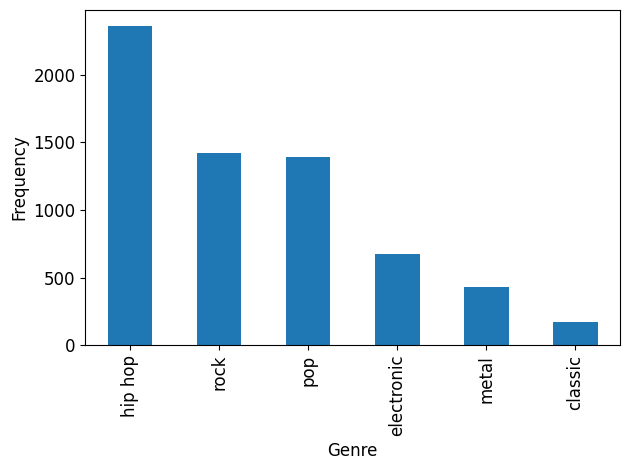

In [4]:
import matplotlib.pyplot as plt

plt.figure()
# Anzahl der Einträge pro Genre
genre_counts = df['Genre'].value_counts()
print(genre_counts)
# Histogramm erstellen
#plt.figure(figsize=(8, 6))
genre_counts.plot(kind='bar')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
#plt.title('bar chart of class imbalance')
plt.tight_layout()
plt.savefig('../figures/genre_hist.pdf')
print(f"Anzahl an Songs: {df.shape[0]}")

Genre
hip hop       2361
rock          1418
pop           1391
electronic     677
metal          430
classic        169
Name: count, dtype: int64
Anzahl an Songs: 6446


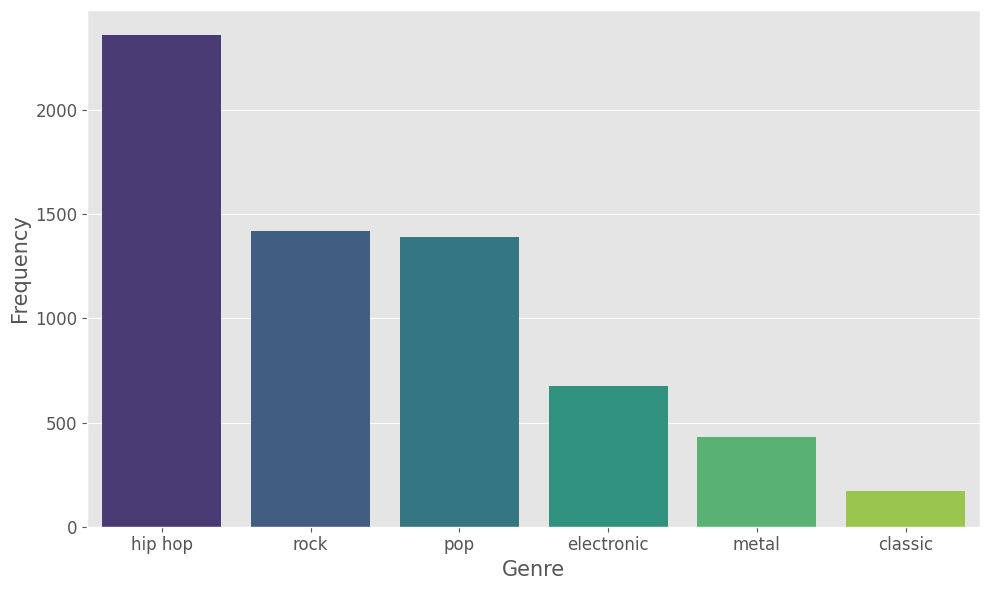

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setzen Sie den Stil auf "ggplot" für ein ansprechenderes Aussehen
plt.style.use('ggplot')

# Anzahl der Einträge pro Genre
genre_counts = df['Genre'].value_counts()
print(genre_counts)

# Histogramm erstellen
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('Genre', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.savefig('../figures/nn/genre_hist2.pdf')
print(f"Anzahl an Songs: {df.shape[0]}")


### Designmatrix und Target erstellen

In [6]:
features_drop = ['Genre', 'Unnamed: 0']

X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [7]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)
num_classes = len(Y.value_counts())

# label um One-Hot-Encoding hinterher wieder zu übersetzen
genre_mapping = Y.columns
label = []
for index, genre in enumerate(genre_mapping):
    label.append(genre)
    print("Genre", index, ":", genre)

Genre 0 : classic
Genre 1 : electronic
Genre 2 : hip hop
Genre 3 : metal
Genre 4 : pop
Genre 5 : rock


### Split in Train, Validation und Test 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42)

### Transformation und Skalierung der Features

In [9]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
# Fit NUR auf train...
transformer = QuantileTransformer(output_distribution="normal")
transformer.fit(X_train)

# ... dann transform auf alle
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

# Werte der Attribute mit MinMax auf [-1,1] skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit wieder auf train...
scaler.fit(X_train)

# ... dann wieder transform
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Modell

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model_from_params(params):
    num_hidden_layers = params['num_hidden_layers']
    activation_function = params['activation_function']
    dropout_rate = params['dropout_rate']
    units_per_layer = [params['units_1'],params['units_2'],params['units_3'],params['units_4']]

    model = Sequential()
    model.add(Dense(units=units_per_layer[0], activation=activation_function, input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))

    for i in range(1, num_hidden_layers+1):
        if i < len(units_per_layer):
            model.add(Dense(units=units_per_layer[i], activation=activation_function))
            model.add(Dropout(dropout_rate))

    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    return model


### Kombinationen aller Hyperparameter

In [11]:
import itertools

param_space = {
    'num_hidden_layers': [2, 3],
    'units_1': [128, 256],
    'units_2': [256, 512],
    'units_3': [512],
    'units_4': [1024],
    'dropout_rate': [0.2, 0.3, 0.4],
    'activation_function': ['relu', 'LeakyReLU'],
    'batch_size' : [64, 128, 256, 512, 1024],
    'early_stopping_patience': [15, 20],
    'reduce_lr_factor': [0.1],
    'reduce_lr_patience': [5],
    'reduce_lr_min_lr': [1e-7],
    'optimizer': ['adam','nadam']
}

#param_space = {
#    'num_hidden_layers': [2, 3],
#    'units_1': [64, 128, 256],
#    'units_2': [128, 256, 512],
#    'units_3': [256, 512, 1024],
#    'units_4': [512, 1024],
#    'dropout_rate': [0.3, 0.5, 0.7],
#    'activation_function': ['relu', 'LeakyReLU'],
#    'batch_size' : [128, 256, 512],
#    'early_stopping_patience': [5, 10, 15],
#    'reduce_lr_factor': [0.1, 0.5, 0.9],
#    'reduce_lr_patience': [5, 10, 15],
#    'reduce_lr_min_lr': [1e-7, 1e-5, 1e-3],
#}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")

We have a total of 960 combinations:


### Hyperparameteroptimierung

In [12]:
import time

# Start der Zeitmessung
start_time = time.time()

search_results = []

search_results = []

k_folds = 3
skf = StratifiedKFold(n_splits=k_folds)

for idx, params in enumerate(param_combis):
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")
    
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []
    
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, np.argmax(Y_train, axis=1))):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train.reset_index(drop=True).iloc[train_index], Y_train.reset_index(drop=True).iloc[val_index]
        
        filepath = f"../model_fold/model_fold_{idx+1}_fold_{fold_idx+1}.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
        this_model = build_model_from_params(params)
        
        batch_size = params['batch_size']
        nb_epoch = 60

        early_stopping = EarlyStopping(monitor='val_loss', patience=params['early_stopping_patience'], mode='min', restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=params['reduce_lr_factor'], patience=params['reduce_lr_patience'], mode='min', min_lr=params['reduce_lr_min_lr'])
        fit_results = this_model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[checkpoint, early_stopping, reduce_lr], verbose=0)
        
        # Extract the best validation scores
        best_val_epoch = np.argmax(fit_results.history['val_accuracy'])
        val_accuracies.append(np.max(fit_results.history['val_accuracy']))
        val_losses.append(fit_results.history['val_loss'][best_val_epoch])
        
        # Get training accuracy and loss
        best_model = load_model(filepath)
        train_loss, train_acc = best_model.evaluate(X_train_fold, Y_train_fold)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
    
    # Store results
    search_results.append({
        **params,
        'best_val_accuracy': np.mean(val_accuracies),
        'val_accuracy_std': np.std(val_accuracies),
        'best_val_loss': np.mean(val_losses),
        'val_loss_std': np.std(val_losses),
        'best_train_accuracy': np.mean(train_accuracies),
        'train_accuracy_std': np.std(train_accuracies),
        'best_train_loss': np.mean(train_losses),
        'train_loss_std': np.std(train_losses)
    })

# Ende der Zeitmessung
end_time = time.time()

# Berechnung der verstrichenen Zeit in Stunden
elapsed_time_hours = (end_time - start_time) / 3600

print(f"Die Ausführung dieser Zelle hat {elapsed_time_hours} Stunden gedauert.")

Start run 1/960: Parameters: {'num_hidden_layers': 2, 'units_1': 128, 'units_2': 256, 'units_3': 512, 'units_4': 1024, 'dropout_rate': 0.2, 'activation_function': 'relu', 'batch_size': 64, 'early_stopping_patience': 15, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1e-07, 'optimizer': 'adam'}


2023-07-27 10:31:04.124700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


86/86 [==============================] - 1s 5ms/step - loss: 0.6849 - accuracy: 0.7407
Start run 2/960: Parameters: {'num_hidden_layers': 2, 'units_1': 128, 'units_2': 256, 'units_3': 512, 'units_4': 1024, 'dropout_rate': 0.2, 'activation_function': 'relu', 'batch_size': 64, 'early_stopping_patience': 15, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1e-07, 'optimizer': 'nadam'}
86/86 [==============================] - 1s 4ms/step - loss: 0.8086 - accuracy: 0.6876
Start run 3/960: Parameters: {'num_hidden_layers': 2, 'units_1': 128, 'units_2': 256, 'units_3': 512, 'units_4': 1024, 'dropout_rate': 0.2, 'activation_function': 'relu', 'batch_size': 64, 'early_stopping_patience': 20, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1e-07, 'optimizer': 'adam'}
86/86 [==============================] - 1s 3ms/step - loss: 0.7838 - accuracy: 0.6956
Start run 4/960: Parameters: {'num_hidden_layers': 2, 'units_1': 128, 'units_2': 256, 'units_3': 512, 

### Sichern der Hyperparameter in csv Datei

In [17]:
import pandas as pd

resultsDF = pd.DataFrame(search_results)
resultsDF['delta_acc'] = (resultsDF['best_train_accuracy']-resultsDF['best_val_accuracy'])/resultsDF['best_val_accuracy']
resultsDF.to_csv('../data/optimization_results_chris_2707.csv', index=False)
resultsDF = pd.read_csv('../data/optimization_results_chris_2707.csv')
resultsDF.head()

,num_hidden_layers,units_1,units_2,units_3,units_4,dropout_rate,activation_function,batch_size,early_stopping_patience,reduce_lr_factor,...,optimizer,best_val_accuracy,val_accuracy_std,best_val_loss,val_loss_std,best_train_accuracy,train_accuracy_std,best_train_loss,train_loss_std,delta_acc
0,2,128,256,512,1024,0.2,relu,64,15,0.1,...,adam,0.664893,0.013605,0.919707,0.007329,0.734723,0.004310,0.708006,0.016334,0.105024
1,2,128,256,512,1024,0.2,relu,64,15,0.1,...,nadam,0.658829,0.008308,0.924822,0.009612,0.696655,0.027048,0.795172,0.060625,0.057413
2,2,128,256,512,1024,0.2,relu,64,20,0.1,...,adam,0.660525,0.004077,0.918309,0.005210,0.726362,0.022240,0.723870,0.044019,0.099673
3,2,128,256,512,1024,0.2,relu,64,20,0.1,...,nadam,0.657617,0.008000,0.928546,0.010507,0.724422,0.027498,0.727636,0.064672,0.101587
4,2,128,256,512,1024,0.2,relu,128,15,0.1,...,adam,0.660283,0.006314,0.921833,0.006159,0.716540,0.018764,0.756286,0.034833,0.085200


### graphische Darstellung der Performanceänderung

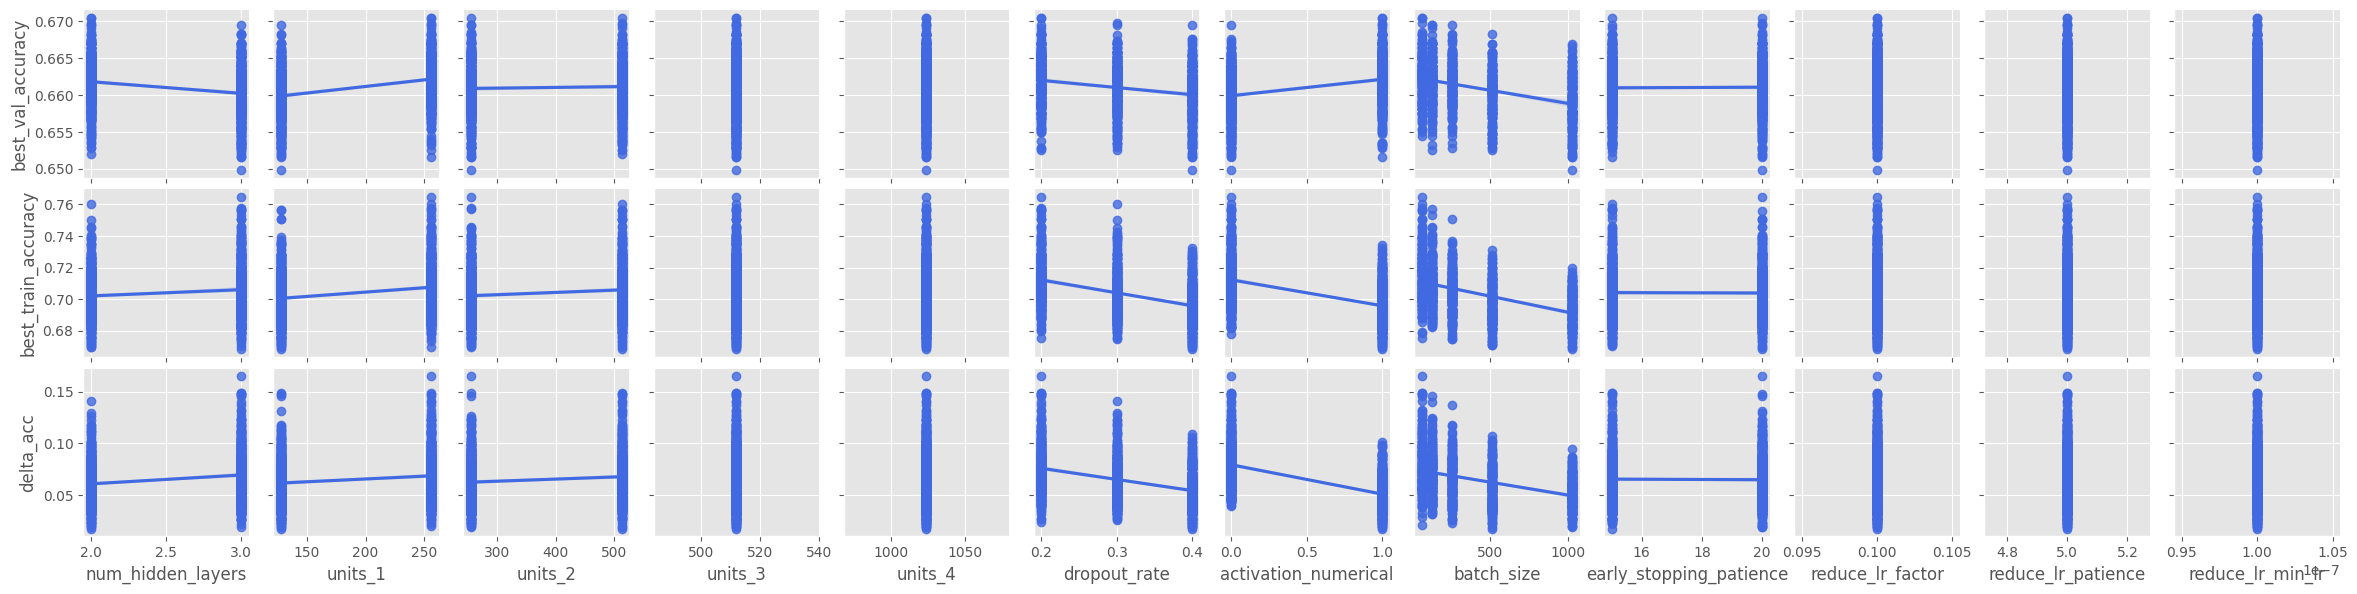

In [18]:
import seaborn as sns

# Mapping der activation_function auf numerische Werte
activation_mapping = {'relu': 0, 'LeakyReLU': 1}
resultsDF['activation_numerical'] = resultsDF['activation_function'].map(activation_mapping)

x_vars = [
    'num_hidden_layers',
    'units_1',
    'units_2',
    'units_3',
    'units_4',
    'dropout_rate',
    'activation_numerical',
    'batch_size',
    'early_stopping_patience',
    'reduce_lr_factor',
    'reduce_lr_patience',
    'reduce_lr_min_lr'
]

y_vars = [
    'best_val_accuracy',
    'best_train_accuracy',
    'delta_acc'
]

sns.pairplot(resultsDF, x_vars=x_vars, y_vars=y_vars, kind='reg', height=2, plot_kws={'color':'royalblue'})
plt.savefig('../figures/nn/HPO_parameter.pdf', format='pdf')

### Auswählen der besten Hyperparameter-Kombination

In [54]:
def calculate_score(row):
    # Bestmöglicher Score ist 
    best_score = 1.0
    
    # Berechnung des Scores basierend auf Delta-Accuracy und Best Validation Accuracy
    delta_acc_score = 1.0 - abs(row['delta_acc'])  # Je kleiner das Delta, desto besser der Score
    best_val_acc_score = row['best_val_accuracy']  # Je größer die Best Validation Accuracy, desto besser der Score
    
    #Gewichte
    w1=0.5
    w2=1
    
    # Gesamtscore berechnen
    score = (w1 * delta_acc_score + w2 * best_val_acc_score) / 2
    
    # Normalisierung des Scores auf den Bereich [0, 1]
    normalized_score = score / best_score
    
    return normalized_score

# Score-Spalte hinzufügen
resultsDF['score'] = resultsDF.apply(calculate_score, axis=1)
resultsDF = resultsDF.sort_values('score', ascending=False)
resultsDF.head()

,num_hidden_layers,units_1,units_2,units_3,units_4,dropout_rate,activation_function,batch_size,early_stopping_patience,reduce_lr_factor,...,val_accuracy_std,best_val_loss,val_loss_std,best_train_accuracy,train_accuracy_std,best_train_loss,train_loss_std,delta_acc,activation_numerical,score
102,2,128,256,512,1024,0.4,LeakyReLU,64,20,0.1,...,0.007111,0.918197,0.007612,0.675437,0.012839,0.843299,0.026905,0.020702,1,0.575694
475,2,256,512,512,1024,0.4,LeakyReLU,512,20,0.1,...,0.005336,0.914237,0.006937,0.684288,0.004174,0.831094,0.006352,0.028424,1,0.575582
232,2,128,512,512,1024,0.4,LeakyReLU,512,15,0.1,...,0.008137,0.929927,0.012168,0.670951,0.013015,0.860416,0.039955,0.017276,1,0.575459
277,2,256,256,512,1024,0.2,LeakyReLU,1024,15,0.1,...,0.006155,0.923673,0.004332,0.681985,0.021427,0.831463,0.047966,0.027209,1,0.575158
110,2,128,256,512,1024,0.4,LeakyReLU,256,20,0.1,...,0.004532,0.926754,0.008342,0.676163,0.009392,0.854147,0.025830,0.023300,1,0.574559


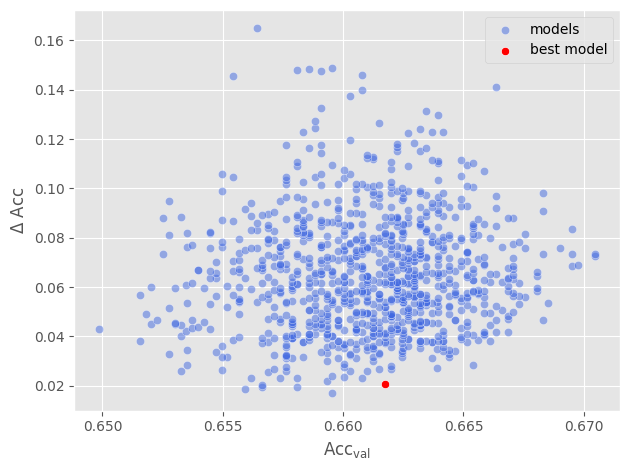

In [55]:
import matplotlib.pyplot as plt

best_params = resultsDF.head(1)

# Scatterplot erstellen
sns.scatterplot(data=resultsDF, x='best_val_accuracy', y='delta_acc', alpha=0.5, color='royalblue', label='models')
sns.scatterplot(data=best_params, x='best_val_accuracy', y='delta_acc', color='red', label='best model')

# Achsentitel hinzufügen
plt.xlabel('Acc$_\mathrm{val}$', fontsize=12)
plt.ylabel('$\Delta$ Acc', fontsize=12)

plt.tight_layout()

# Plot anzeigen
plt.savefig('../figures/HPO_scatter.pdf')

In [56]:
best_params = resultsDF.iloc[0]
model = build_model_from_params(best_params)
model.summary()

Model: "sequential_2887"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12988 (Dense)         (None, 128)               2560      
                                                                 
 dropout_10101 (Dropout)     (None, 128)               0         
                                                                 
 dense_12989 (Dense)         (None, 256)               33024     
                                                                 
 dropout_10102 (Dropout)     (None, 256)               0         
                                                                 
 dense_12990 (Dense)         (None, 512)               131584    
                                                                 
 dropout_10103 (Dropout)     (None, 512)               0         
                                                                 
 dense_12991 (Dense)         (None, 6)             

### Das beste Modell

In [58]:
batch_size = best_params['batch_size']
nb_epoch = 300

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['early_stopping_patience'], mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=best_params['reduce_lr_factor'], best_patience=best_params['reduce_lr_patience'], mode='min', min_lr=best_params['reduce_lr_min_lr'])

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], verbose=0)

In [59]:
Y_pred = model.predict(X_test)

41/41 [==============================] - 0s 6ms/step


### Evaluation

In [60]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.plot(network_history.history['loss'], color='royalblue')
    plt.plot(network_history.history['val_loss'], color='red')
    plt.legend(['Training', 'Validation'])
    plt.tight_layout()
    plt.savefig('../figures/Loss.pdf')
    
    plt.figure()
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.plot(network_history.history['accuracy'], color='royalblue')
    plt.plot(network_history.history['val_accuracy'], color='red')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.tight_layout()
    plt.savefig('../figures/Acc.pdf')

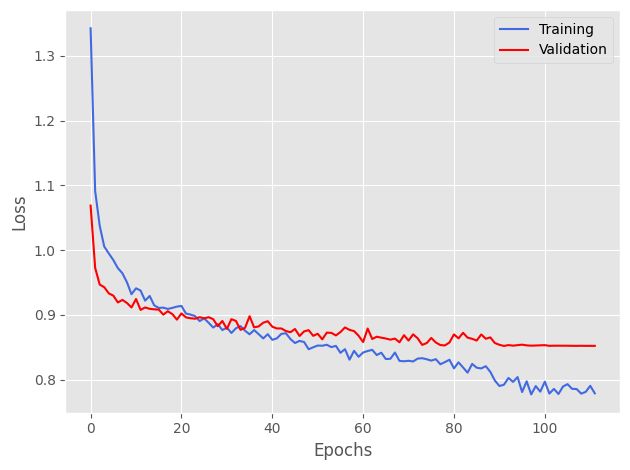

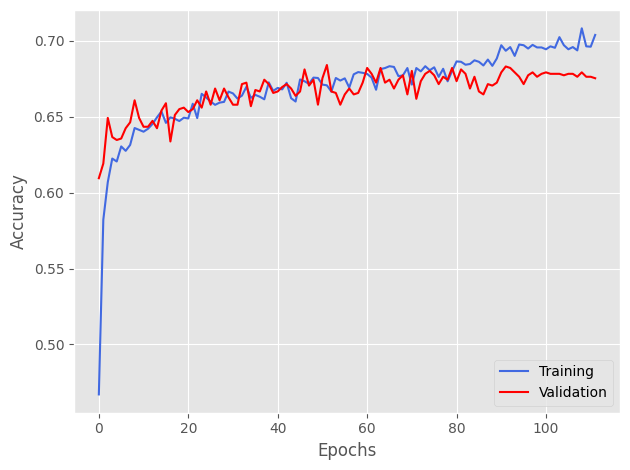

In [61]:
plot_history(hist)

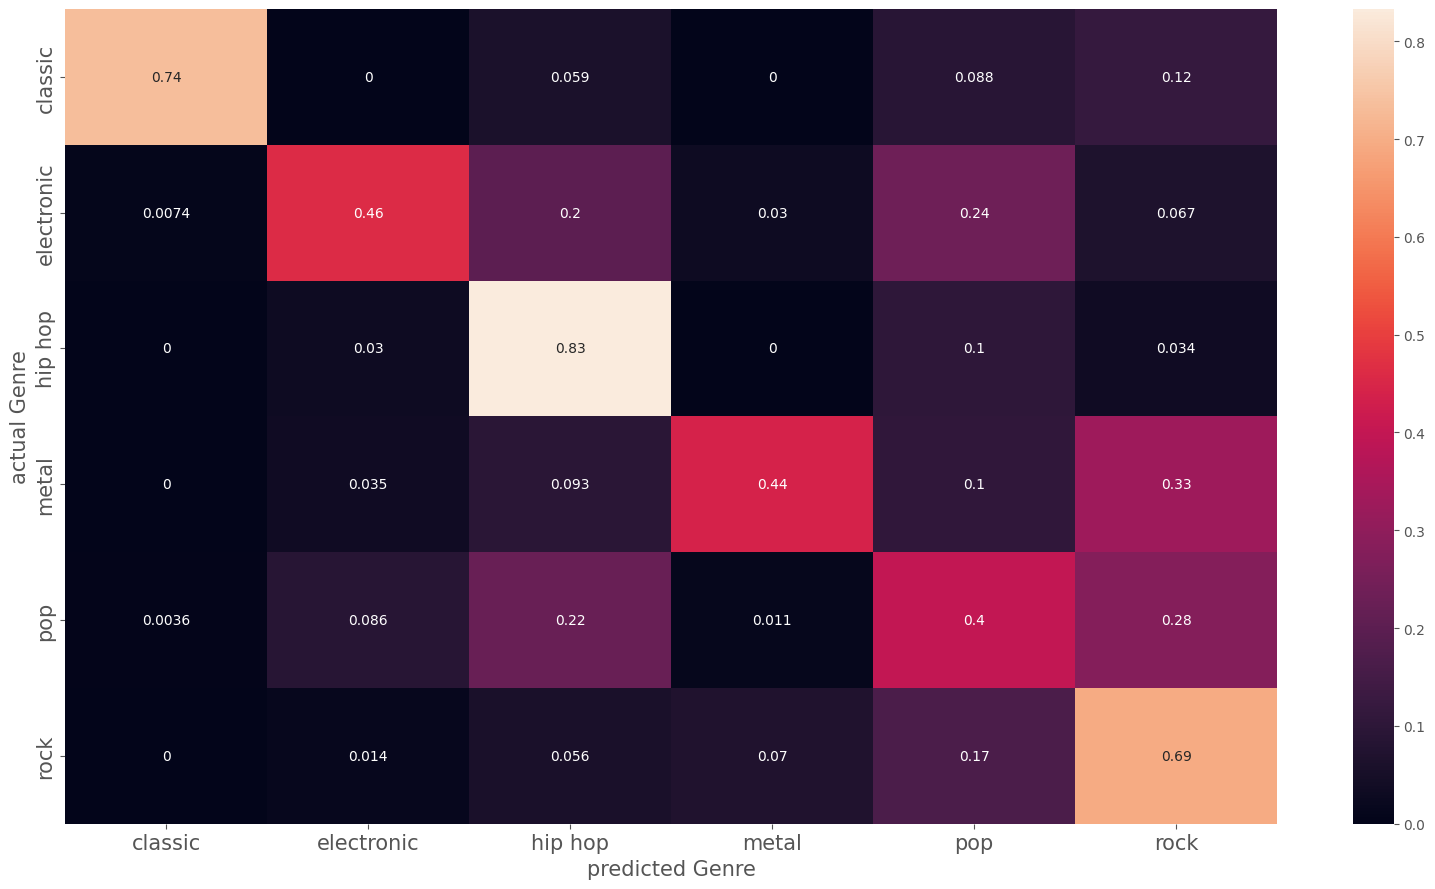

In [62]:
from sklearn.metrics import confusion_matrix

Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('predicted Genre', fontsize=15)
plt.ylabel('actual Genre', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../figures/nn/confusion_matrix_nn.png')
plt.show()

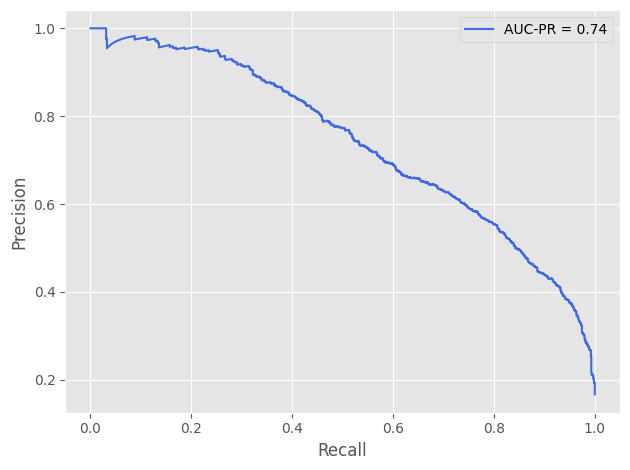

In [63]:
from sklearn.metrics import precision_recall_curve, auc

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_pred, pd.DataFrame):
    Y_pred = Y_pred.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}", color='royalblue')
plt.xlabel('Recall',fontsize=12)
plt.ylabel('Precision',fontsize=12)
plt.legend()
plt.tight_layout()
#plt.title('Precision-Recall Curve')
plt.savefig('../figures/PR_curve.pdf')

hip hop: AUC-PR = 0.888
classic: AUC-PR = 0.886
rock: AUC-PR = 0.718
metal: AUC-PR = 0.559
electronic: AUC-PR = 0.542
pop: AUC-PR = 0.487


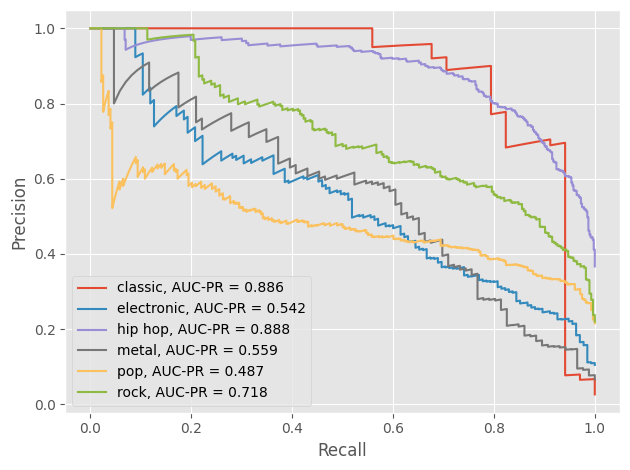

In [64]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend()
plt.tight_layout()
#plt.title("Precision-Recall Curve")
plt.savefig('../figures/nn/PR_curve_genres.pdf')

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")

In [65]:
Y_pred = model.predict(X_test)

# Konvertiere die Vorhersagen in diskrete Klassen
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Konvertiere die Ground-Truth-Labels in diskrete Klassen
Y_test_classes = np.argmax(Y_test, axis=1)

# Berechne die Accuracy
accuracy = np.mean(Y_pred_classes == Y_test_classes)
print("Accuracy:", accuracy)


41/41 [==============================] - 0s 4ms/step
Accuracy: 0.6410852713178294
